# Определение перспективного тарифа для телеком компании

#### Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
#### Описание тарифов
##### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
4. минута разговора: 3 рубля
5. сообщение: 3 рубля
6. 1 Гб интернет-трафика: 200 рублей
##### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
4. минута разговора: 1 рубль
5. сообщение: 1 рубль
6. 1 Гб интернет-трафика: 150 рублей

*Обратите внимание*: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных
##### Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

##### Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

##### Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

##### Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

##### Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гиг

## Шаг 1. Откроем файлы с данными и изучим общую информацию

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [3]:
calls_df = pd.read_csv('/datasets/calls.csv')
internet_df = pd.read_csv('/datasets/internet.csv')
messages_df = pd.read_csv('/datasets/messages.csv')
tariffs_df = pd.read_csv('/datasets/tariffs.csv')
users_df = pd.read_csv('/datasets/users.csv')

##### Вывод
Рассмотрим каждый из датасетов по отдельности. При необходимости будем соединять данные.

### Пользователи

In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
users_df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [137]:
users_df.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [7]:
print('Количество дубликатов: {}'.format(users_df.duplicated().sum()))

Количество дубликатов: 0


In [8]:
users_df['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

##### Выводы
* Нам доступны данные 500 пользователей, 462 из которых все еще пользуются тарифом:
    1. 351 – Смарт
    2. 149 – Ультра

* Пропусков, которые нужно заполнить, и дубликатов в данных нет;

* Следующие признаки необходимо привести к типу DateTime:
    1. reg_date дата подключения тарифа;
    2. churn_date дата прекращения пользования тарифом.

### Тарифы

In [9]:
tariffs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [10]:
tariffs_df.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
# Поменяем имя одного столбца
tariffs_df = tariffs_df.rename(columns={'tariff_name': 'tariff'})

##### Выводы
* Пропусков нет, которые нужно заменить.
* Название столбца было измененно в связи с тем что имя такого столбца есть в users_df. Для merge

### Сообщения

In [12]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [13]:
messages_df.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
messages_df.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [15]:
print('Количество дубликатов: {}'.format(messages_df.duplicated().sum()))

Количество дубликатов: 0


 ##### Выводы
* Пропусков нет, которые нужно заменить.
* message_date дату сообщения нужно  привести к DateTime.

### Интернет

In [16]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [17]:
internet_df.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [18]:
print('Количество дубликатов: {}'.format(internet_df.duplicated().sum()))

Количество дубликатов: 0


In [19]:
internet_df.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [20]:
print('Количество сессий объема потраченного за сессию интернет-трафика менее 1 Мб и больше 0: {}'.format(len(internet_df.query('mb_used < 1 and mb_used > 0'))))

print('Количество сессий объема потраченного за сессию интернет-трафика менее 1 Мб: {}'.format(len(internet_df.query('mb_used < 1 '))))



Количество сессий объема потраченного за сессию интернет-трафика менее 1 Мб и больше 0: 101
Количество сессий объема потраченного за сессию интернет-трафика менее 1 Мб: 19699


##### Выводы
* Пропусков нет, которые нужно заменить.
* Объём потраченного за сессию интернет-трафика указан в мегабайтах, в то время, как в тарифе в гигабайтах. Таким образом, если пользователь израсходует объем трафика, предоставленный тарифным планом, для анализа нам потребуется привести дополнительный объем трафика к гигабайтам, чтобы рассчитать стоимость;
* session_date дату интернет-сессии нужно привести к DateTime.
* 19699 сесия имеют объём потраченного за сессию интернет-трафика менее 1 Мб. Если сессия зарегестрирована значит трафик был, правда странно если он равен 0. Но исходя из условий  - Наш оператор округляет вверх значения мегабайтов. Применим метод np.ceil для приведения ВСЕХ значений к большему числу, а так же все нули заменим на 1 и после поменяем тип на INT

### Звонки

In [21]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [22]:
calls_df.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [23]:
print('Количество дубликатов: {}'.format(calls_df.duplicated().sum()))

Количество дубликатов: 0


In [24]:
print('Количетсво звонком у которых - длительность звонка менее 1 минуты: {}'.format(len(calls_df[calls_df.duration < 1])))


Количетсво звонком у которых - длительность звонка менее 1 минуты: 47927


In [25]:
calls_df.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


##### Выводы
* Пропусков нет, которые нужно заменить.
* call_date дату звонков нужно привести к DateTime.
* 47927 звонков было совершено меньше минкты Здесь такая же ситуация и такое же правило как с интернетом. Поэтому применим метод np.ceil для приведения ВСЕХ значений к большему числу и после поменяем тип на INT

# Шаг 2. Подготовка данных

### Восстановим пропуски

In [26]:
# Звонки
calls_df['duration'] = calls_df['duration'].apply(np.ceil)
calls_df.loc[calls_df['duration'] == 0 ,'duration'] = 1
# Интернет-сессии
internet_df['mb_used'] = internet_df['mb_used'].apply(np.ceil)
internet_df.loc[internet_df['mb_used'] == 0 ,'mb_used'] = 1

### Приведем данные к нужным типам

In [27]:
dtformat = '%Y-%m-%d'

def to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=dtformat)

# Даты
to_datetime(users_df, ['reg_date', 'churn_date'])
to_datetime(calls_df, ['call_date'])
to_datetime(messages_df, ['message_date'])
to_datetime(internet_df, ['session_date'])
# Минуты и мегабайты
calls_df['duration'] = calls_df['duration'].astype('int64')
internet_df['mb_used'] = internet_df['mb_used'].astype('int64')

### Посчитаем значения, необходимые для анализа каждого пользователя

In [28]:
users_costs = pd.DataFrame()

### Количество сделанных звонков и израсходованных минут разговора по месяцам¶

In [29]:
calls_df['month'] = pd.DatetimeIndex(calls_df['call_date']).month

calls_in_month = calls_df.pivot_table(
    index=['month', 'user_id'],
    values='duration',
    aggfunc=['count', 'sum']
)

temp_df = pd.DataFrame(calls_in_month.to_records())

users_costs['user_id'] = temp_df['user_id']
users_costs['month']   = temp_df['month']
users_costs['calls']   = temp_df.iloc[:, 2]
users_costs['minutes'] = temp_df.iloc[:, 3]

### Количество отправленных сообщений по месяцам

In [30]:
messages_df['month'] = pd.DatetimeIndex(messages_df['message_date']).month

messages_in_month = messages_df.pivot_table(
    index=['month', 'user_id'],
    values='id',
    aggfunc='count'
)

temp_df = pd.DataFrame(messages_in_month.to_records()).rename(columns={'id': 'messages'})

users_costs = users_costs.merge(temp_df, on=['user_id', 'month'], how='outer')

### Объем израсходованного интернет-трафика по месяцам

In [31]:
internet_df['month'] = pd.DatetimeIndex(internet_df['session_date']).month

internet_in_month = internet_df.pivot_table(
    index=['month', 'user_id'],
    values='mb_used',
    aggfunc='sum'
)

temp_df = pd.DataFrame(internet_in_month.to_records())

users_costs = users_costs.merge(temp_df, on=['user_id', 'month'], how='outer')

In [32]:
users_costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3174 non-null float64
minutes     3174 non-null float64
messages    2717 non-null float64
mb_used     3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


##### Выводы
Теперь, в одном датафрейме мы видим следующую информацию по пользователям в разрезе месяцев:

1. количество сделанных звонков и израсходованных минут разговора;
2. количество отправленных сообщений;
3. объем израсходованного интернет-трафика в мегабайтах.

### Замена пропусков

После формирования датафрейма по месяцам появились пропуски. Некоторые пользователи в некоторые месяцы пользовались не всеми услугами. Например, кто-то только мобильным интернетом. Заполним пропуски нулями и позже посмотрим на распределение.

In [33]:
na_features = ['calls', 'minutes', 'messages', 'mb_used']

for f in na_features:
    # При соединении датафреймов Pandas привел типы к float64 из-за пропусков,
    # поэтому явно приведем их к int64
    users_costs[f] = users_costs[f].fillna(0).astype('int64')

In [34]:
users_costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3214 non-null int64
minutes     3214 non-null int64
messages    3214 non-null int64
mb_used     3214 non-null int64
dtypes: int64(6)
memory usage: 175.8 KB


In [35]:
users_costs.head()

,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15,99,7,2730
1,1032,1,61,397,38,24158
2,1045,1,1,9,5,2348
3,1055,1,64,568,30,17115
4,1071,1,24,200,16,15625


### Помесячная выручка с каждого пользователя

In [36]:
# Добавим в датафрейм информацию о пользователях и тарифах
users_costs = users_costs.merge(users_df, on='user_id', how='left').merge(tariffs_df, on='tariff', how='left')

In [37]:
# Перерасход минут, сообщений и трафика посчитаем как разность между месячным значением и включенным в тариф
users_costs['minutes_over']  = users_costs['minutes'] - users_costs['minutes_included']
users_costs['messages_over'] = users_costs['messages'] - users_costs['messages_included']
users_costs['mb_used_over']  = users_costs['mb_used'] - users_costs['mb_per_month_included']

In [38]:
users_costs.head()

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,mb_used_over
0,1005,1,15,99,7,2730,67,NaT,Набережные Челны,Афанасий,...,50,15360,500,550,200,3,3,-401,-43,-12630
1,1032,1,61,397,38,24158,31,NaT,Ульяновск,Инна,...,50,15360,500,550,200,3,3,-103,-12,8798
2,1045,1,1,9,5,2348,48,NaT,Улан-Удэ,Джемма,...,50,15360,500,550,200,3,3,-491,-45,-13012
3,1055,1,64,568,30,17115,39,NaT,Казань,Луиза,...,50,15360,500,550,200,3,3,68,-20,1755
4,1071,1,24,200,16,15625,20,2018-08-31,Омск,Гектор,...,50,15360,500,550,200,3,3,-300,-34,265


Положительные значения указывают на перерасход. Отрицательные на остаток в рамках тарифа.

In [39]:
def calc_monthly_finance(row):
    """
    Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика,
    остаток умножим на значение из тарифного плана.
    """
    
    minutes_price = 0
    messages_price = 0
    mb_used_price = 0
    
    # стоимость дополнительных минут
    if row['minutes_over'] > 0:
        minutes_price = row['minutes_over'] * row['rub_per_minute']

    # стоимость дополнительных сообщений
    if row['messages_over'] > 0:
        messages_price = row['messages_over'] * row['rub_per_message']

    # стоимость дополнительного трафика
    if row['mb_used_over'] > 0:
        mb_used_price = (row['mb_used_over'] / 1024) * row['rub_per_gb']
    
    return minutes_price + messages_price + mb_used_price

In [40]:
users_costs['rub_monthly_fee_over'] = users_costs.apply(calc_monthly_finance, axis=1)
users_costs['rub_monthly_fee_total'] = users_costs['rub_monthly_fee'] + users_costs['rub_monthly_fee_over']

In [41]:
users_costs.head()

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1005,1,15,99,7,2730,67,NaT,Набережные Челны,Афанасий,...,500,550,200,3,3,-401,-43,-12630,0.000000,550.000000
1,1032,1,61,397,38,24158,31,NaT,Ульяновск,Инна,...,500,550,200,3,3,-103,-12,8798,1718.359375,2268.359375
2,1045,1,1,9,5,2348,48,NaT,Улан-Удэ,Джемма,...,500,550,200,3,3,-491,-45,-13012,0.000000,550.000000
3,1055,1,64,568,30,17115,39,NaT,Казань,Луиза,...,500,550,200,3,3,68,-20,1755,546.773438,1096.773438
4,1071,1,24,200,16,15625,20,2018-08-31,Омск,Гектор,...,500,550,200,3,3,-300,-34,265,51.757812,601.757812


In [42]:
smart = users_costs.query("tariff == 'smart'")

In [43]:
print('Количество пользователей смарт: {}'.format(len(smart.groupby('user_id'))))

Количество пользователей смарт: 350


In [44]:
ultra = users_costs.query("tariff == 'ultra'")

In [45]:
print('Количество пользователей юльтра: {}'.format(len(ultra.groupby('user_id'))))

Количество пользователей юльтра: 148


##### Выводы

1. данные готовы и собраные в 1 таблицу для анализа;
2. от всех пропусков избавились;
3. в результирующей таблице пользователей со смарт оказалось - 350, а с юльтра - 148.

# Шаг 3. Анализ данных

### Опишем поведение клиентов оператора, исходя из выборки.

In [46]:
values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total']

# Сделаем сводную таблицу по тарифам в разрезе месяцев
tariff_monthly_users_costs = users_costs.pivot_table(
    index=['tariff', 'month'],
    values=values
)

In [47]:
smart_monthly_costs = tariff_monthly_users_costs.loc['smart']
smart_monthly_costs

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,8528.588235,18.235294,209.647059,154.895910,704.895910
2,11617.344828,24.086207,306.310345,262.159752,812.159752
3,15131.207792,31.857143,400.532468,583.213271,1133.213271
4,13486.080357,30.741071,377.000000,384.781878,934.781878
5,15832.751773,33.773050,398.404255,611.004377,1161.004377
6,15822.445122,33.402439,406.701220,614.601038,1164.601038
7,15771.398010,33.751244,419.288557,635.629392,1185.629392
8,16640.212766,33.638298,433.191489,726.647008,1276.647008
9,16332.615385,33.638462,440.080769,667.753456,1217.753456


In [48]:
ultra_monthly_costs = tariff_monthly_users_costs.loc['ultra']
ultra_monthly_costs

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,13154.666667,33.777778,440.888889,0.000000,1950.000000
2,11788.333333,21.958333,304.666667,23.095703,1973.095703
3,17553.513514,32.297297,503.081081,54.254645,2004.254645
4,16845.254545,31.563636,470.072727,45.474077,1995.474077
5,19383.194030,37.850746,524.865672,105.022738,2055.022738
6,18943.928571,41.726190,492.428571,82.109724,2032.109724
7,20516.571429,49.846154,560.296703,158.562092,2108.562092
8,19595.878505,48.439252,524.570093,121.230195,2071.230195
9,19224.043478,52.286957,553.643478,63.776749,2013.776749


#### Минуты разговора, количество сообщений и объём интернет-трафика в среднем необходимые пользователям каждого тарифа в месяц

In [49]:
tariff_usage = tariff_monthly_users_costs.pivot_table(
    index='tariff',
    values=values
)
tariff_usage

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
tariff,,,,,
smart,15085.107080,31.413211,397.374228,595.673948,1145.673948
ultra,18224.477581,43.714983,509.356551,88.972927,2038.972927


##### Выводы

1. Пользователи тарифа Ультра более активны, но пользователи тарифа Смарт тратят в среднем в 6 раз больше на дополнительные пакеты услуг. Оператор может использовать это для маркетинговой компании.
2. Оператору больше денег приносит тариф Ультра, даже с учетом того, что в среднем пользователи не выходят за границы тарифных лимитов, а пользователи тарифа Смарт не тратят столько денег, чтобы перегнать стоимость тарифа Ультра. Таким образом, для пользователя выгоднее тариф Смарт.

### Дисперсия и стандартное отклонение

Нормальное распредление определяют среднее и дисперсия. Они позволяют понять насколько шумные сейчас данные.

#### Минуты разговора

In [115]:
smart['minutes'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: minutes, dtype: float64

In [116]:
ultra['minutes'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: minutes, dtype: float64

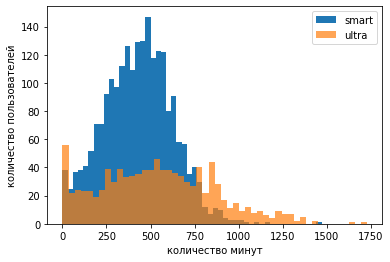

In [138]:
plt.hist(smart['minutes'], bins=50, label='smart')
plt.hist(ultra['minutes'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.xlabel('количество минут')
plt.ylabel('количество пользователей')
plt.show()

In [118]:
smart_minutes_var = np.var(smart['minutes'], ddof=1)
ultra_minutes_var = np.var(ultra['minutes'], ddof=1)
print('Дисперсия минут тарифа смарт {}'.format(smart_minutes_var))
print('Дисперсия минут тарифа Ультра {}'.format(ultra_minutes_var))

Дисперсия минут тарифа смарт 37974.774627825
Дисперсия минут тарифа Ультра 106105.72682307787


In [119]:
smart_dict_minutes = {'Стандартное отклонение (мин)': smart['minutes'].std(),
             'Дисперсия': smart_minutes_var}
smart_d_minutes = pd.Series(smart_dict_minutes)
ultra_dict_minutes = {'Стандартное отклонение (мин)': ultra['minutes'].std(),
             'Дисперсия': ultra_minutes_var}
ultra_d_minutes = pd.Series(ultra_dict_minutes)

smart_ultra_minutes = pd.DataFrame({'Смарт': smart_d_minutes, 'Ультра': ultra_d_minutes})


### Вывод

In [120]:
smart_ultra_minutes

,Смарт,Ультра
Стандартное отклонение (мин),194.871174,325.738740
Дисперсия,37974.774628,106105.726823


#### Количество сообщений

In [121]:
smart['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [122]:
ultra['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

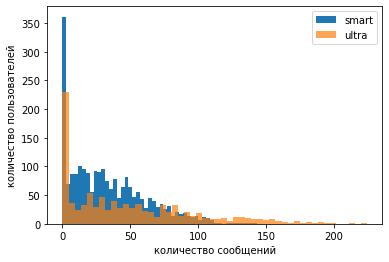

In [124]:
plt.hist(smart['messages'], bins=50, label='smart')
plt.hist(ultra['messages'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.xlabel('количество сообщений')
plt.ylabel('количество пользователей')
plt.show()

In [126]:
smart_messages_var = np.var(smart['messages'], ddof=1)
ultra_messages_var = np.var(ultra['messages'], ddof=1)
print('Дисперсия сообщений тарифа смарт {}'.format(smart_messages_var))
print('Дисперсия сообщений тарифа ультра {}'.format(ultra_messages_var))

Дисперсия сообщений тарифа смарт 796.8129584480083
Дисперсия сообщений тарифа ультра 2285.266142544674


In [127]:
smart_dict_messages = {'Стандартное отклонение (сообщения)': smart['messages'].std(),
             'Дисперсия': smart_messages_var}
smart_d_messages = pd.Series(smart_dict_messages)
ultra_dict_messages = {'Стандартное отклонение (сообщения)': ultra['messages'].std(),
             'Дисперсия': ultra_messages_var}
ultra_d_messages = pd.Series(ultra_dict_messages)

smart_ultra_messages = pd.DataFrame({'Смарт': smart_d_messages, 'Ультра': ultra_d_messages})

### Вывод

In [128]:
smart_ultra_messages

,Смарт,Ультра
Стандартное отклонение (сообщения),28.227876,47.804457
Дисперсия,796.812958,2285.266143


#### Интернет-трафик

In [129]:
smart['mb_used'].describe()

count     2229.000000
mean     16237.184388
std       5879.795158
min          0.000000
25%      12662.000000
50%      16540.000000
75%      20078.000000
max      38627.000000
Name: mb_used, dtype: float64

In [130]:
ultra['mb_used'].describe()

count      985.000000
mean     19488.703553
std      10097.107541
min          0.000000
25%      11787.000000
50%      19324.000000
75%      26866.000000
max      49793.000000
Name: mb_used, dtype: float64

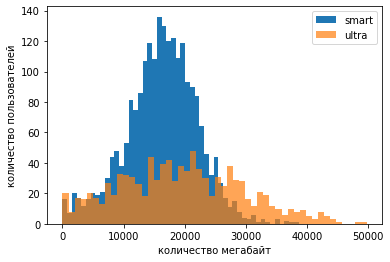

In [131]:
plt.hist(smart['mb_used'], bins=50, label='smart')
plt.hist(ultra['mb_used'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.xlabel('количество мегабайт')
plt.ylabel('количество пользователей')
plt.show()

In [132]:
smart_mb_var = np.var(smart['mb_used'], ddof=1)
ultra_mb_var = np.var(ultra['mb_used'], ddof=1)
print('Дисперсия мегабайт тарифа смарт {}'.format(smart_mb_var))
print('Дисперсия мегабайт тарифа ультра {}'.format(ultra_mb_var))

Дисперсия мегабайт тарифа смарт 34571991.09480103
Дисперсия мегабайт тарифа ультра 101951580.68642029


In [133]:
smart_dict_mb = {'Стандартное отклонение (мегабайт)': smart['mb_used'].std(),
             'Дисперсия': smart_mb_var}
smart_d_mb = pd.Series(smart_dict_mb)
ultra_dict_mb = {'Стандартное отклонение (мегабайт)': ultra['mb_used'].std(),
             'Дисперсия': ultra_mb_var}
ultra_d_mb = pd.Series(ultra_dict_mb)

smart_ultra_mb = pd.DataFrame({'Смарт': smart_d_mb, 'Ультра': ultra_d_mb})

### Вывод

In [135]:
smart_ultra_mb

,Смарт,Ультра
Стандартное отклонение (мегабайт),5.879795e+03,1.009711e+04
Дисперсия,3.457199e+07,1.019516e+08


### Cреднее количество по Москве и другим регионам

In [139]:
moscow = users_costs['city'] == 'Москва'
users_costs['city'].where(moscow, 'Другой регион', inplace=True)

city_monthly_costs = users_costs.pivot_table(
    index=['city', 'month'],
    values=values
)

In [140]:
city_usage = city_monthly_costs.pivot_table(
    index='city',
    values=values
)
city_usage

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
city,,,,,
Другой регион,15681.785666,35.268458,424.594742,451.974045,1398.514093
Москва,17603.175813,33.944639,455.792652,388.889460,1483.854730


### Вывод
* По средним значениям выручки пользователей Москвы и регионов мы видим, что разница в ~100 рублей.
* В Москве больше тратят трафик интернета. А так сообщения и минуты приблизительно одинаково тратятся 

# Шаг 4. Проверим гипотезы

### 1 - Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Нулевая гипотеза H₀:

> Средняя выручка пользователей тарифов "Ультра" и "Смарт" НЕ различается

Исходя из H₀ формулируется альтернативная гипотеза H₁:

> Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается

Пороговое значение alpha (критический уровень статистической значимости) зададим равным 5%.

In [141]:
alpha = 0.05 # критический уровень статистической значимости
             # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    smart['rub_monthly_fee_total'], 
    ultra['rub_monthly_fee_total'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.009674149482176e-180
Отвергаем нулевую гипотезу


### Вывод
Средняя выручка пользователей тарифов «Ультра» и «Смарт» дейтсвительно различаются - наша гипотеза подтвердилась. Об этом говорит почти Нулевая(H0)вероятность. Случайно получить такое отличие в значениях практически не получится.

### 2 - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза H₀:

> Cредняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов

Исходя из H₀ формулируется альтернативная гипотеза H₁:

> Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Пороговое значение alpha (критический уровень статистической значимости) зададим равным 5%.

In [143]:
alpha = 0.05 # критический уровень статистической значимости
             # если p-value окажется меньше него - отвергнем гипотезу

moscow = users_costs.query("city == 'Москва'")['rub_monthly_fee_total']
other_cities = users_costs.query("city == 'Другой регион'")['rub_monthly_fee_total']

results = st.ttest_ind(moscow, other_cities)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5220687323801865
Не получилось отвергнуть нулевую гипотезу


### Вывод
Вероятность получить одинаковую среднюю выручку составляет 52% - это слишком большая вероятность следовательно гипотеза не подтвердилась и средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

# Шаг 5. Общий вывод

Из двух наших гипотез подтвердилась только одна:
> Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

В первой гипотезе шанс что средняя выручка будет одинакова равна 
$$ 8 * \frac{1}{10^{180}}$$
Это очень маленький процент и поэтому наша гипотеза **подтвердилась**

Во второй гипотезе вероятность отличий равна 48% Это маленькая вероятность и наша гипотеза **не подтвердилась**

Так же были построены графики и было выявлены различия использования пакета и построены следующие таблицы

In [144]:
smart_ultra_minutes

,Смарт,Ультра
Стандартное отклонение (мин),194.871174,325.738740
Дисперсия,37974.774628,106105.726823


In [145]:
smart_ultra_messages

,Смарт,Ультра
Стандартное отклонение (сообщения),28.227876,47.804457
Дисперсия,796.812958,2285.266143


In [146]:
smart_ultra_mb

,Смарт,Ультра
Стандартное отклонение (мегабайт),5.879795e+03,1.009711e+04
Дисперсия,3.457199e+07,1.019516e+08


**Отвечая на вопрос** "какой тариф лучше" исходя из вышеприведенного анализа выборочных совокупностей и гипотезы, можем сказать:

для оператора – тариф Ультра потому что он приносит больше денег
для пользователя – тарифа Смарт потому что полного пакета в среднем хватает пользователям